<i><b>Public AI</b></i>
<br>
# Grad-CAM이란?

### _Objective_

* Grad-CAM은 Class Activation Map의 일반화된 모델로, Global Average Pooling을 이용하지 않고 Gradient을 통해, Class Activation Map을 계산하는 방법론입니다.<br>


In [9]:
%matplotlib inline
import os
import cv2
from PIL import Image

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## 예제 이미지) 

이번에는 강아지와 레서판다 이미지를 통해, Class Activation Map을 시각화해보도록 하겠습니다.

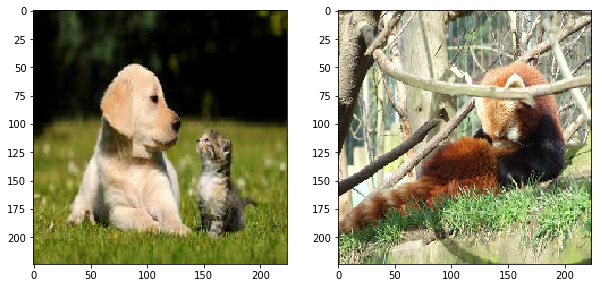

In [10]:
# 이미지 시각화하기 
dog_path = get_file("dog_and_cat.jpg",
                    "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/dog_and_cat.jpg")
dog_image = Image.open(dog_path)
dog_image = np.array(dog_image.resize((224,224)))

panda_path = get_file("redpanda.jpg",
                      "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/redpanda.jpg")
panda_image = Image.open(panda_path)
panda_image = np.array(panda_image.resize((224,224)))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.imshow(panda_image)
plt.show()

# \[ Grad-CAM이란? \]
---

Gradient-weighted CAM은 CAM을 보다 일반화한 시각화 방법론입니다. CAM과 달리, Inference Model을 변형하지 않고도 쓸 수 있다는 점에서 매우 유용합니다.

<br>

## 1. Grad-CAM의 아이디어



### (1) Feature Map에서의 Gradient의 의미

![Imgur](https://i.imgur.com/n3ewNlt.png)

이전 시간에 배웠던 Class Activation Map의 경우, 우리는 각 필터의 중요도를 확인하기 위해 Global Average Pooling으로 필터 별로 요약하고, 거기에 Softmax를 통해 학습을 하였습니다. <br>
대신 Grad-CAM에서는 Gradient에 주목하였습니다.

![Imgur](https://i.imgur.com/iuTUcoG.png)


국소적으로 보았을 때, 출력값은 이 기울기와 Feature Map의 선형결합으로 해석할 수 있습니다.<br>
이를 이용해, CAM 방식에서 구한 Weight 대신 이 기울기로 Weight로 삼았습니다.<br>
그래서 Gradient-Weighted CAM 방식을 일반화된 형태의 CAM 방식이라고 설명합니다.

### (2) Gradient-CAM의 구조도

![Imgur](https://i.imgur.com/BqaK7V4.png)

## 2. Grad-CAM 구현하기


* Grad-CAM은 이전의 방식과 달리, 학습이 따로 필요하지 않습니다.<br>
* 이번에도 VGG 모델을 이용해서 구현하도록 하겠습니다.<br>

### (1) VGG 모델 가져오기

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.imagenet_utils import decode_predictions

vgg16 = VGG16()

### (2) Grad-CAM 부분 구현하기

In [12]:
from tensorflow.keras.models import Model
import tensorflow as tf

In [13]:
image = dog_image - [123.68,116.779,103.939,]

fmap = vgg16.get_layer('block5_conv3').output
output = vgg16.layers[-1].output

grad_model = Model(vgg16.input, [fmap, output])

with tf.GradientTape() as tape:
    conv_outputs, model_outputs = grad_model(image[None])
    
    top_indices = tf.argmax(model_outputs, axis=1)
    top_logit = tf.gather(model_outputs, top_indices, axis=1)

grads = tape.gradient(top_logit, conv_outputs)
channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                    keepdims=True)
heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                         axis=-1, keepdims=True)
heat_map = tf.nn.relu(heat_map)

W0223 14:03:44.430190 4583024064 base_layer.py:1814] Layer block1_conv1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [14]:
@tf.function
def get_gradcam_result(image):
    with tf.GradientTape() as tape:
        conv_outputs, model_outputs = grad_model(image[None])

        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)
    heat_map = tf.squeeze(heat_map)
    return model_outputs, tf.nn.relu(heat_map)

<Br> 
    
## 3. Grad-CAM을 통한 히트맵 시각화


### (1) Heatmap 시각화 메소드 구현하기

In [15]:
def blend_heatmap(image, heatmap, ratio=0.5):
    image = np.array(image)
    heatmap = np.array(heatmap)
    h, w = image.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

### (2) 개 사진 시각화하기 

In [16]:
image = dog_image - [123.68,116.779,103.939,]

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0]

blended_image = blend_heatmap(image, heat_value)

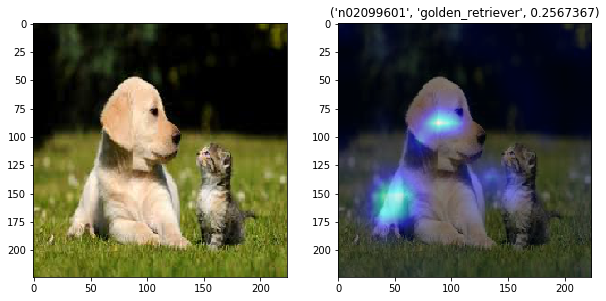

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()

### (3) 레서 판다 시각화하기

In [18]:
image = panda_image - [123.68,116.779,103.939,]

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0]

blended_image = blend_heatmap(image, heat_value)

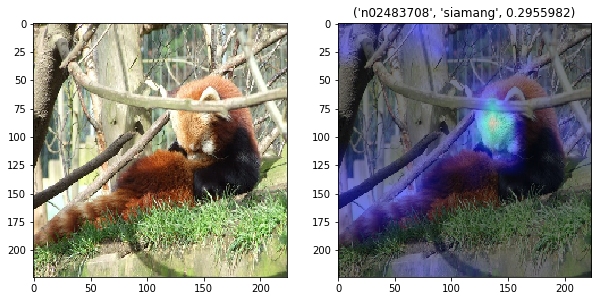

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(panda_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---